In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import itertools as it

In [2]:
def build_normal(loc=0, scale=1.0, size=10, min_=-10.0, max_=10.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    r = np.random.normal(loc=loc, scale=scale, size=size)
    r = np.minimum(np.maximum(min_, r), max_)
    return r

def ret_from_track(df, li_undl):
    return  df[li_undl].pct_change().dropna().values

def get_vol(ret, dt):
    ylds = 1.0+ret
    return np.sqrt(np.mean(np.log(ylds)**2))*np.sqrt(1/dt)
    
def get_basket_vol(df, li_undl, dt, weight):
    ret = ret_from_track(df, li_undl)
    wret = weight*ret
    wret = wret.sum(axis=1)
    return get_vol(wret, dt)

def get_corr(df):
    li_arr = [df[u].values for u in df.columns]
    return np.corrcoef(li_arr)


## Constant vol tracks

In [3]:
np.random.seed(4321)

n_path = 5     # nb of monte carlo paths
rate = 0.02     # rate 0.01=1%
vol = 0.25      # vol 0.25
n_bd = 260*3     # nb of bdays for a path
dt = 1.0/260    # bday duration in year
today = pd.Timestamp.today().date()


ret = (rate-vol**2/2)*dt+vol*np.sqrt(dt)*build_normal(size=(n_bd, n_path))
# vols = np.array([build_normal(loc=0.25, scale=0.0000000001, size=n_bd, min_=0.01, max_=0.60)]*5)
# ret = np.array([[(rate-v**2/2)*dt+v*np.sqrt(dt)*r for v, r in zip(vol, build_normal(size=n_bd))] for vol in vols]).T
ret[0, :] = 0
ylds = (1.0+ret)
tracks = ylds.cumprod(axis=0)

dates = pd.date_range(start=today, periods=n_bd, freq='B')
dfi = pd.DataFrame(data=tracks, index=dates, columns=['track'+str(1+i) for i in range(n_path)])

dfi.info()
display(dfi.head(3))
display(dfi.tail(3))

print('\ncorrel matrix')
print(get_corr(dfi))

print('\nrealised vols')
for u in dfi.columns:
    print(u, get_basket_vol(dfi, [u], dt, [1]))
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 2018-11-05 to 2021-10-29
Freq: B
Data columns (total 5 columns):
track1    780 non-null float64
track2    780 non-null float64
track3    780 non-null float64
track4    780 non-null float64
track5    780 non-null float64
dtypes: float64(5)
memory usage: 36.6 KB


,track1,track2,track3,track4,track5
2018-11-05,1.000000,1.000000,1.000000,1.000000,1.00000
2018-11-06,0.991086,0.988311,1.034504,1.010148,0.98240
2018-11-07,0.996116,0.990276,1.047314,0.987196,0.96086


,track1,track2,track3,track4,track5
2021-10-27,1.135948,1.250656,1.502724,0.923336,1.207163
2021-10-28,1.127822,1.226211,1.487574,0.915478,1.177196
2021-10-29,1.121077,1.234559,1.458207,0.906931,1.165481



correl matrix
[[ 1.          0.58144393 -0.19172154 -0.48877704  0.51785916]
 [ 0.58144393  1.         -0.10650294 -0.50037344  0.6083518 ]
 [-0.19172154 -0.10650294  1.          0.37431378 -0.05018854]
 [-0.48877704 -0.50037344  0.37431378  1.         -0.26009962]
 [ 0.51785916  0.6083518  -0.05018854 -0.26009962  1.        ]]

realised vols
track1 0.253382986213
track2 0.247497900768
track3 0.248481836573
track4 0.252806421326
track5 0.249016458142


## Stochastic vol tracks

In [4]:
np.random.seed(4321)

n_path = 50     # nb of monte carlo paths
rate = 0.02     # rate 0.01=1%
n_bd = 260*3     # nb of bdays for a path
dt = 1.0/260    # bday duration in year
today = pd.Timestamp.today().date()

avg_vol = build_normal(loc=0.2, scale=0.1, size=n_path, min_=0.05, max_=0.50)
# avg_vol = [0.25 for i in range(len(avg_vol))]
vols = np.array([build_normal(loc=v, scale=0.05, size=n_bd, min_=0.01, max_=0.60) for v in avg_vol])
ret = np.array([[(rate-v**2/2)*dt+v*np.sqrt(dt)*r for v, r in zip(vol, build_normal(size=n_bd))] for vol in vols]).T
ret[0, :] = 0
ylds = (1.0+ret)
tracks = ylds.cumprod(axis=0)

dates = pd.date_range(start=today, periods=n_bd, freq='B')
df = pd.DataFrame(data=tracks, index=dates, columns=['track'+str(1+i) for i in range(n_path)])

df.info()
display(df.head(3))
display(df.tail(3))

# print(vols)

print('\ncorrel matrix')
print(get_corr(df))

print('\navg_vol\n', avg_vol)
print('\nrealised vols')
for u in df.columns:
    print(u, get_basket_vol(df, [u], dt, [1]))
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 2018-11-05 to 2021-10-29
Freq: B
Data columns (total 50 columns):
track1     780 non-null float64
track2     780 non-null float64
track3     780 non-null float64
track4     780 non-null float64
track5     780 non-null float64
track6     780 non-null float64
track7     780 non-null float64
track8     780 non-null float64
track9     780 non-null float64
track10    780 non-null float64
track11    780 non-null float64
track12    780 non-null float64
track13    780 non-null float64
track14    780 non-null float64
track15    780 non-null float64
track16    780 non-null float64
track17    780 non-null float64
track18    780 non-null float64
track19    780 non-null float64
track20    780 non-null float64
track21    780 non-null float64
track22    780 non-null float64
track23    780 non-null float64
track24    780 non-null float64
track25    780 non-null float64
track26    780 non-null float64
track27    780 non-null float64
trac

,track1,track2,track3,track4,track5,track6,track7,track8,track9,track10,...,track41,track42,track43,track44,track45,track46,track47,track48,track49,track50
2018-11-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-11-06,0.987303,0.963461,1.002703,0.979849,1.009183,1.013510,1.009098,0.992038,0.959121,0.999629,...,0.980399,0.999856,0.974326,1.024315,1.000871,1.004948,0.985910,0.993153,1.000361,1.008138
2018-11-07,1.008905,0.960229,1.033989,0.969426,1.013075,1.051729,1.019450,1.018911,0.955737,1.002049,...,0.976431,1.000070,0.971902,1.028487,1.001613,1.004049,0.968499,0.990745,0.990748,1.001182


,track1,track2,track3,track4,track5,track6,track7,track8,track9,track10,...,track41,track42,track43,track44,track45,track46,track47,track48,track49,track50
2021-10-27,0.773343,1.913082,2.711954,0.869716,0.941594,1.136665,0.997778,0.523900,0.481725,0.944490,...,0.704888,1.126119,1.024773,0.817012,1.558291,1.061897,0.462366,1.351245,1.188363,1.059571
2021-10-28,0.773207,1.933228,2.821586,0.875928,0.950683,1.140868,1.001124,0.514867,0.479343,0.947372,...,0.703641,1.130267,1.024786,0.817733,1.573375,1.061119,0.468836,1.362433,1.225488,1.071547
2021-10-29,0.769023,2.012587,2.782583,0.876457,0.934136,1.135021,1.001412,0.504362,0.487824,0.943157,...,0.700370,1.128061,1.029170,0.820125,1.597811,1.057791,0.482634,1.351294,1.231786,1.071037



correl matrix
[[ 1.         -0.88309287 -0.63990589 ..., -0.39766278 -0.26744915
  -0.14408651]
 [-0.88309287  1.          0.86982916 ...,  0.35928711  0.03256172
   0.39763571]
 [-0.63990589  0.86982916  1.         ...,  0.174065   -0.26280953
   0.58785882]
 ..., 
 [-0.39766278  0.35928711  0.174065   ...,  1.          0.68257378
  -0.14585191]
 [-0.26744915  0.03256172 -0.26280953 ...,  0.68257378  1.         -0.53669026]
 [-0.14408651  0.39763571  0.58785882 ..., -0.14585191 -0.53669026  1.        ]]

avg_vol
 [ 0.12334785  0.29611947  0.3456347   0.14702073  0.17352326  0.14278287
  0.12488865  0.42282166  0.26573406  0.08676224  0.23301812  0.21310132
  0.28014518  0.0537287   0.05886103  0.05        0.18565703  0.25164901
  0.32800874  0.07748614  0.12208868  0.18709211  0.25554081  0.24184018
  0.23293098  0.3140024   0.19919813  0.27699546  0.06469552  0.13476496
  0.05        0.29865941  0.3746369   0.17025033  0.23650646  0.05276608
  0.25332363  0.05        0.06423293  0.1

## Minimize Basket vol

In [5]:
def get_basket_vol_2(ret, weight, dt):
    wret = weight*ret
    wret = wret.sum(axis=1)
    vol = get_vol(wret, dt)
    return vol

def get_basket_vol_sliding_window(df, undls, dt, weight, period):
    arr = df[undls].values
    ret = arr[1:]/arr[:-1]-1.0
    vols = []
    for start_date in range(len(df)-period):
#         print(start_date, end=',')
        sub_ret = ret[start_date: start_date+period]
        vol = get_basket_vol_2(sub_ret, weight, dt)
        vols.append(vol)
    return vols

def get_energy(vols):
    return np.mean([np.percentile(vols, 20), np.percentile(vols, 10)])


In [6]:
from math import factorial

def get_comb(n, k):
    return int(factorial(n) / factorial(k) / factorial(n - k))

get_comb(50, 4)

230300


n_trial 1000
best_undls ['track31', 'track36', 'track39', 'track46']
best_energy 0.0360040520097
CPU times: user 10.4 s, sys: 44.4 ms, total: 10.4 s
Wall time: 10.4 s


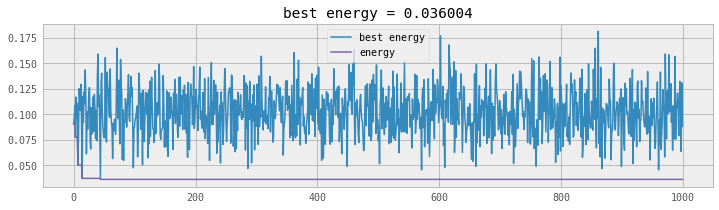

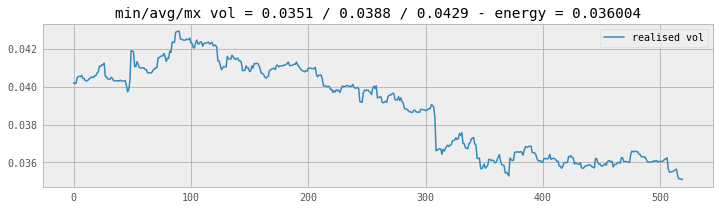

In [7]:
%%time

n_undl = 4
period = 260
weight = np.ones(n_undl)*1.0/n_undl
n_trial = int(1e3)

comb = [e for e in it.combinations(df.columns, n_undl)]
np.random.shuffle(comb)
n_trial = np.minimum(len(comb), n_trial)

best_energy = float('inf')
best_undls = []
li_energy = []

# for k in range(n_trial):
#     undls = np.random.choice(df.columns, size=n_undl, replace=False)

for c in comb[:n_trial]:
    undls = list(c)
    vols = get_basket_vol_sliding_window(df, undls, dt, weight, period)
    energy = get_energy(vols)
    if energy < best_energy:
        best_energy = energy
        best_undls = undls[:]
    li_energy.append([energy, best_energy])

dfs = pd.DataFrame(li_energy, columns=['best energy', 'energy'])

print('\nn_trial', n_trial)
print('best_undls', best_undls)
print('best_energy', best_energy)
dfs.plot(figsize=(12, 3), title='best energy = {:.6f}'.format(best_energy));

vols = get_basket_vol_sliding_window(df, best_undls, dt, weight, period)
dfv = pd.DataFrame(vols, columns=['realised vol'])
energy = get_energy(vols)
s = 'min/avg/mx vol = {:.4f} / {:.4f} / {:.4f} - energy = {:.6f}'.format(min(vols), np.mean(vols), max(vols), energy)
dfv.plot(figsize=(12, 3), title=s);
